/Users/nicolasmartinet/miniforge3/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 200, Average Reward: 303.63801607322256
Episode 400, Average Reward: 277.27903999393254
Episode 600, Average Reward: 326.031131025915
Episode 800, Average Reward: 285.60645164628545
Episode 1000, Average Reward: 318.38793560711275
Episode 1200, Average Reward: 255.13654391515124
Episode 1400, Average Reward: 247.01886394376453
Episode 1600, Average Reward: 248.42472612435603
Episode 1800, Average Reward: 269.39062517614593
Episode 2000, Average Reward: 327.12227816518185


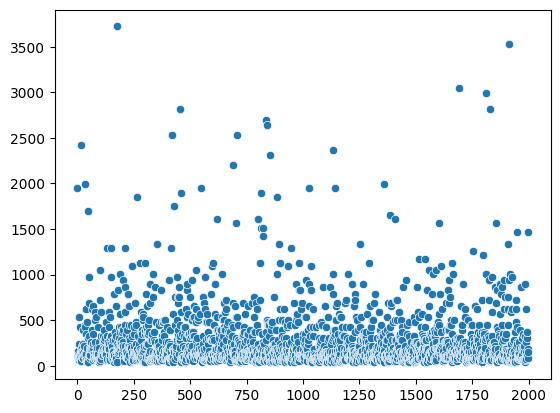

In [164]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns

class ActorCriticNetwork(nn.Module):
    def __init__(self):
        super(ActorCriticNetwork, self).__init__()
        self.fc1 = nn.Linear(4, 64)
        self.fc2 = nn.Linear(64, 64)
        self.probs = nn.Linear(64, 2)
        self.fc_critic = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        probs = torch.relu(self.probs(x))
        action_probs = torch.softmax(probs, dim=-1)
        value = self.fc_critic(x)
        return action_probs, value

class PPOAgent:
    def __init__(self, network):
        self.network = network
        self.optimizer = optim.Adam(self.network.parameters(), lr=0.01)
        self.clip_epsilon = 0.2
    
    def calculate_discounted_returns(self, rewards, dones, gamma=0.99):
        returns = []
        cumulative_return = 0

        for reward, done in zip(reversed(rewards), reversed(dones)):
            cumulative_return = reward + gamma * cumulative_return * (1 - done)
            returns.insert(0, cumulative_return)

        return returns

    def run_episode(self, env):
        state = env.reset()[0]
        rewards = []
        log_probs = []
        states = []
        actions = []
        dones = []

        for t in range(1000):
            action, prob = self.get_action(state)
            new_state, reward, done, _,_ = env.step(action)
            rewards.append(reward)
            log_prob = torch.log(prob)
            log_probs.append(log_prob)
            states.append(state)
            actions.append(action)
            dones.append(done)

            state = new_state

            if done:
                break

        returns = self.calculate_discounted_returns(rewards, dones)
        
        return states, actions, log_probs, returns, dones


    def get_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        probs, _ = self.network(state)
        action = torch.multinomial(probs, 1) # something like tensor([[0]]) or tensor([[1]])
        return action.item(), probs[0, action.item()] # something like (1, 0.5719183087348938)


    def update(self, states, actions, old_probs, rewards, dones):
        states = torch.tensor(states).float()
        actions = torch.tensor(actions)
        old_probs = torch.tensor(old_probs)
        rewards = torch.tensor(rewards)
        dones = torch.tensor(dones)

        for _ in range(10):  # multiple iterations for each update
            current_probs, values = self.network(states)
            current_probs = current_probs.gather(1, actions.unsqueeze(1)).squeeze(1)
            ratios = current_probs / old_probs
            advantages = rewards - values.squeeze(1)
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1.0 - self.clip_epsilon, 1.0 + self.clip_epsilon) * advantages
            policy_loss = -torch.min(surr1, surr2).mean()

            value_loss =  0.5*advantages.pow(2).mean()

            self.optimizer.zero_grad()
            (policy_loss + value_loss).backward()
            self.optimizer.step()

def main():
    env = gym.make('CartPole-v1')
    network = ActorCriticNetwork()
    agent = PPOAgent(network)

    episode_rewards = []
    for i_episode in range(2000):

        states, actions, log_probs, returns, dones = agent.run_episode(env)
        
        agent.update(states, actions, log_probs, returns, dones)
        episode_reward = sum(returns)
        episode_rewards.append(episode_reward)

        if (i_episode + 1) % 200 == 0:
            avg_reward = sum(episode_rewards[-200:]) / 200
            print(f'Episode {i_episode + 1}, Average Reward: {avg_reward}')

    return episode_rewards

if __name__ == '__main__':
    r = main()
    sns.scatterplot(x=range(len(r)), y=r)

/Users/nicolasmartinet/miniforge3/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


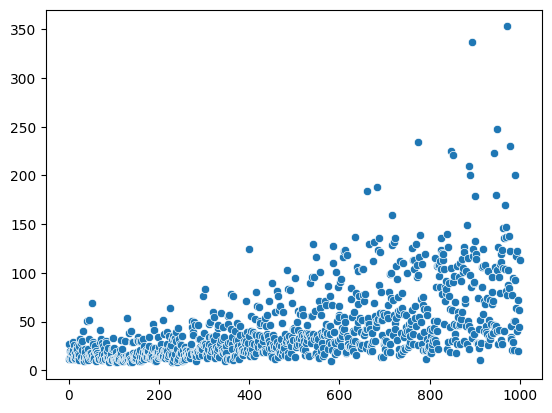

In [176]:
import torch
import torch.nn as nn
import torch.optim as optim
import gym
import numpy as np

class ActorCritic(nn.Module):
    def __init__(self):
        super(ActorCritic, self).__init__()
        self.l1 = nn.Linear(4, 25)
        self.l2 = nn.Linear(25, 50)
        self.actor = nn.Linear(50, 2)
        self.critic = nn.Linear(50, 1)

    def forward(self, x):
        x = torch.relu(self.l1(x))
        x = torch.relu(self.l2(x))
        return self.actor(x), self.critic(x)

def compute_returns(next_value, rewards, masks, gamma=0.99):
    R = next_value
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + gamma * R * masks[step]
        returns.insert(0, R)
    return returns

def train(actor_critic, optimizer, episodes=1000):
    env = gym.make('CartPole-v1')
    
    episode_rewards = []

    for episode in range(episodes):
        state = env.reset()[0]
        
        log_probs, values, rewards, masks = [], [], [], []
        entropy = 0
        episode_reward = 0

        for _ in range(2000): # CartPole-v1 max episode steps = 500
            state = torch.from_numpy(state).float().unsqueeze(0)
            action_probs, value = actor_critic(state)
            dist = torch.distributions.Categorical(logits=action_probs)
            action = dist.sample().unsqueeze(0)
            next_state, reward, done, _,_ = env.step(action.item())

            episode_reward += reward

            log_prob = dist.log_prob(action).unsqueeze(0)
            entropy += dist.entropy().mean()

            log_probs.append(log_prob)
            values.append(value)
            rewards.append(torch.tensor([reward], dtype=torch.float32).unsqueeze(0))
            masks.append(torch.tensor([1-done], dtype=torch.float32).unsqueeze(0))

            state = next_state

            if done:
                break

        next_state = torch.from_numpy(next_state).float().unsqueeze(0)
        _, next_value = actor_critic(next_state)
        returns = compute_returns(next_value, rewards, masks)

        log_probs = torch.cat(log_probs)
        returns = torch.cat(returns).detach()
        values = torch.cat(values)

        advantage = returns - values

        actor_loss = -(log_probs * advantage.detach()).mean()
        critic_loss = advantage.pow(2).mean()

        optimizer.zero_grad()
        (actor_loss + 0.5 * critic_loss - 0.001 * entropy).backward()
        optimizer.step()

        episode_rewards.append(episode_reward)

        if episode % 100 == 0:
            avg_reward = sum(episode_rewards[-100:]) / 100
            #print(f"Episode {episode}, average reward over the last 100 episodes: {avg_reward}")
        
    sns.scatterplot(x=range(len(episode_rewards)), y=episode_rewards)

actor_critic = ActorCritic()
optimizer = optim.Adam(actor_critic.parameters(), lr=0.001)
train(actor_critic, optimizer)
